In [49]:
# for removing warning of depriciation
import warnings
warnings.filterwarnings('ignore', category=Warning)

## GLH Json File access and putting a userID column according to file name

In [50]:
import os
import json
import pandas as pd
import numpy as np
from math import radians

# Create a DataFrame to store merged_dataframe
final_df = pd.DataFrame()

# CHANGE PATH
path = "C:\\Users\\Kaiser\\Documents\\Google map\\COMPLETE CODE ITERATION\\Final code"


# Loop through each file in the directory
for filename in os.listdir(path):
    if filename.endswith('.json'):
        with open(os.path.join(path, filename), encoding='utf-8') as f:
            data = json.load(f)
            # Normalize placeVisit
            places_df = pd.json_normalize(data, record_path='timelineObjects', meta=['placeVisit'], errors='ignore')
            places_df = places_df.rename(columns={
                'placeVisit.location.latitudeE7': 'Place visit latitude',
                'placeVisit.location.longitudeE7': 'Place visit longitude',
                'placeVisit.location.name': 'Place visit name',
                'placeVisit.locationConfidence': 'Place visit confidence',
                'placeVisit.duration.startTimestamp': 'Place visit start time',
                'placeVisit.duration.endTimestamp': 'Place visit end time'
            })

            # Normalize activitySegment
            activities_df = pd.json_normalize(data, record_path='timelineObjects', meta=['activitySegment'], errors='ignore')
            activities_df = activities_df.rename(columns={
                'activitySegment.startLocation.latitudeE7': 'Start Latitude',
                'activitySegment.startLocation.longitudeE7': 'Start Longitude',
                'activitySegment.endLocation.latitudeE7': 'End Latitude',
                'activitySegment.endLocation.longitudeE7': 'End Longitude',
                'activitySegment.activityType': 'Mode of trip',
                'activitySegment.confidence': 'Confidence of Mode',
                'activitySegment.duration.startTimestamp': 'Trip start time',
                'activitySegment.duration.endTimestamp': 'Trip end time',
                'activitySegment.simplifiedRawPath.points': 'Trip path'
            })
            activities_df['Probability'] = activities_df['activitySegment.activities'].apply(lambda x: x[0]['probability'] if isinstance(x, list) and len(x) > 0 else None)

            # Merge the two dataframes
            merged_df = pd.merge(activities_df, places_df, left_on='Trip end time', right_on='Place visit start time')

            # Drop any rows with missing values
            merged_df = merged_df.dropna(subset=['Trip end time', 'Place visit start time']) 
            
            # Adding a new column 'userID' with the file name for all rows
            user_id = filename.split('_')[0]
            merged_df['userID'] = user_id
            
            # Append to final_df
            final_df = final_df.append(merged_df, ignore_index=True)



df = final_df[['userID', 'Mode of trip','Probability', 'Confidence of Mode', 'Start Latitude', 'Start Longitude', 'End Latitude', 'End Longitude',
               'Trip start time', 'Trip end time', 'Place visit start time', 'Place visit name', 'Place visit confidence',
               'Place visit end time', 'Place visit latitude', 'Place visit longitude', 'Trip path']]




## Lat lon in conventional notation

In [51]:
df[['Start Latitude', 'Start Longitude', 'End Latitude','End Longitude','Place visit latitude' ,'Place visit longitude']] = df[['Start Latitude', 'Start Longitude', 'End Latitude', 'End Longitude','Place visit latitude' ,'Place visit longitude']] / 10**7

In [52]:
# user_data = df[df["userID"] == "2004070"]
# user_data

In [53]:
print(df['Probability'].mean())

63.13304606928487


## Dealing with time zone

In [54]:
import datetime
import pytz
tz = pytz.timezone('Asia/Dhaka')
def convert_to_timezone(row, column_name):
    dt = datetime.datetime.fromisoformat(str(row[column_name]).rstrip('Z'))
    dt = dt.replace(tzinfo=pytz.utc).astimezone(tz)
    return dt

In [55]:
df['Trip start time'] = df.apply(lambda row: convert_to_timezone(row, 'Trip start time'), axis=1)
df['Trip end time'] = df.apply(lambda row: convert_to_timezone(row, 'Trip end time'), axis=1)
df['Place visit start time']=df.apply(lambda row: convert_to_timezone(row, 'Place visit start time'), axis=1)
df['Place visit end time']=df.apply(lambda row: convert_to_timezone(row, 'Place visit start time'), axis=1)

df['Trip start time'] = df['Trip start time'].apply(lambda dt: dt.replace(tzinfo=None))
df['Trip end time'] = df['Trip end time'].apply(lambda dt: dt.replace(tzinfo=None))

## Traverse through raw point for intermediate lat lon and timestamp

In [56]:
trip_coordinates = []
timestamps = []

for _, row in df.iterrows():
    if not pd.isna(row['Start Latitude']):
        trip = []
        timestamp = []

        # Start location, time of the trip, and timestamp list
        trip.append((row['Start Latitude'], row['Start Longitude']))
        timestamp.append(row['Trip start time'])
        
        
        # Check if there are intermediate locations
        if isinstance(row['Trip path'], list):
            # Add the intermediate location points to the trip list
            for point in row['Trip path']:
                lat = point['latE7'] / 10**7
                lng = point['lngE7'] / 10**7
                trip.append((lat, lng))
                
                # Intermediate timestamp string to dt
                dt_intermediate = datetime.datetime.fromisoformat(point['timestamp'].rstrip('Z'))
                dt_intermediate = dt_intermediate.replace(tzinfo=pytz.utc).astimezone(tz)
                dt_intermediate = dt_intermediate.replace(tzinfo=None)
                timestamp.append(dt_intermediate.strftime('%Y-%m-%d %H:%M:%S.%f%z'))
                #timestamp.append(dt_intermediate)

        trip.append((row['End Latitude'], row['End Longitude']))
        timestamp.append(row['Trip end time'])
        
        # Append trip coordinates and timestamps to their respective lists
        trip_coordinates.append(trip)
        timestamps.append(timestamp)

data = {
    'Trip coordinates': trip_coordinates, 
    'Timestamps': timestamps
}

new_df = pd.DataFrame(data)
df = pd.concat([df, new_df], axis=1)


## Isolating a date column

In [57]:
df['Date of trip']=df['Trip start time'].dt.date

## Necessary column

In [58]:
columns=['userID','Date of trip','Trip start time','Timestamps','Mode of trip','Trip coordinates','Trip end time', 'Start Latitude',
       'Start Longitude', 'End Latitude', 'End Longitude','Place visit start time',
        'Place visit end time','Place visit latitude', 'Place visit longitude' ]  #'Confidence of Mode''Place visit name','Place visit confidence'
df=df[columns]
#df['Trip start time'] = df['Trip start time'].apply(lambda dt: dt.replace(tzinfo=None))
#df['Trip end time'] = df['Trip end time'].apply(lambda dt: dt.replace(tzinfo=None))

## Calculation of trip distance,duration and velocity

In [59]:
from math import radians, cos, sin, asin, sqrt

#function to calculate the distance
def distance_calc(coord1,coord2):
    lat1,lon1=coord1
    lat2,lon2=coord2
    # Convert decimal degrees to radians
    lat1,lon1,lat2,lon2=map(radians, [lat1, lon1, lat2, lon2])
    # Haversine formula
    dlon=lon2-lon1
    dlat=lat2-lat1
    a=sin(dlat/2)**2+cos(lat1)*cos(lat2)*sin(dlon/2)**2
    c=2*asin(sqrt(a))
    #Radius of earth in kilometers
    r=6371
    return c*r

def velocity_calc(coordi,times):
    total_distance=0
    total_time=0
    velocity_segment = []
    time_interval = []
    for i in range(1,len(coordi)):
        coordi1=coordi[i-1]
        coordi2=coordi[i]
        distance=distance_calc(coordi1,coordi2)
        time1=pd.to_datetime(times[i-1])
        time2=pd.to_datetime(times[i])
        time_diff=(time2-time1).total_seconds()/3600 # convert to hour
        time_interval.append(time_diff)
#         print(f"Timestamps: {times[i - 1]} - {times[i]}")
#         print(f"Converted time1: {time1}")
#         print(f"Converted time2: {time2}")
#         print(time_diff)
        if time_diff!=0:
                velocity_segment.append(distance / time_diff)
                total_distance += distance
                total_time += time_diff
#                 print( velocity_segment)
        
    velocity=total_distance/total_time
    return pd.Series({'Velocity(km/hr)':velocity,'Trip distance(km)':total_distance,'Trip Duration(hr)':total_time,'velocity_segment': velocity_segment,'Segment interval' : time_interval})

df[['Velocity(km/hr)', 'Trip distance(km)', 'Trip Duration(hr)','Velocity segment','Segment interval']]=df.apply(lambda row: velocity_calc(row['Trip coordinates'], row['Timestamps']), axis=1)

## Dataframe is ready to use

In [60]:
df.dtypes

userID                                        object
Date of trip                                  object
Trip start time                       datetime64[ns]
Timestamps                                    object
Mode of trip                                  object
Trip coordinates                              object
Trip end time                         datetime64[ns]
Start Latitude                               float64
Start Longitude                              float64
End Latitude                                 float64
End Longitude                                float64
Place visit start time    datetime64[ns, Asia/Dhaka]
Place visit end time      datetime64[ns, Asia/Dhaka]
Place visit latitude                         float64
Place visit longitude                        float64
Velocity(km/hr)                              float64
Trip distance(km)                            float64
Trip Duration(hr)                            float64
Velocity segment                              

## Setting threshold distance to remove smallest trip 
## Adjusting GLH data according to SURVEY DATE

In [61]:
df = df[(df['Trip distance(km)'] >= 0.2)]

In [62]:
survey_date = pd.Timestamp('2023-07-14')
df = df[df['Date of trip'] >= survey_date]

In [63]:
#df

## Finding User's home location 

In [64]:
new_df = df.copy()
new_df['Place visit start time'] = pd.to_datetime(new_df['Place visit start time']) 
new_df['Place visit end time'] = pd.to_datetime(new_df['Place visit end time']) 


night_visit = new_df[
    (new_df['Place visit start time'].dt.hour >= 20) | 
    (new_df['Place visit end time'].dt.hour < 7)
]

grouped = night_visit.groupby('userID')


home_address_df = pd.DataFrame(columns=['userID', 'Home Latitude', 'Home Longitude'])

for user_id, group in grouped:
    home_lat = group['Place visit latitude'].mode().iloc[0]
    home_long = group['Place visit longitude'].mode().iloc[0]
    home_address_df = home_address_df.append({'userID': user_id, 'Home Latitude': home_lat, 'Home Longitude': home_long}, ignore_index=True)


In [65]:
home_address_df

,userID,Home Latitude,Home Longitude
0,1704083,23.740836,90.377888
1,1804037,23.725370,90.391448
2,1804083,23.726566,90.392660
3,1804124,23.755547,90.359004
4,1904079,23.725370,90.391448
5,1904082,23.726566,90.392660
6,1904083,23.741422,90.430935
7,2004070,23.725370,90.391448
8,2004097,23.799330,90.351914
9,2102094,23.793837,90.342392


## Analysis-01 : Loading CSV file of TRIP Tracker user's containing HOME Address and calculating deviation of GLH Home address distance

In [66]:
from math import radians, sin, cos, sqrt, atan2
def calculate_distance(lat1,lon1,lat2,lon2):
    R=6371  
    lat1_rad,lon1_rad,lat2_rad,lon2_rad = map(radians,[lat1,lon1,lat2,lon2])
    dlat=lat2_rad-lat1_rad
    dlon=lon2_rad-lon1_rad
    a=sin(dlat/2)**2+cos(lat1_rad)*cos(lat2_rad)*sin(dlon/2)**2
    c=2*atan2(sqrt(a),sqrt(1-a))
    distance=R*c

    return distance

In [67]:
manual_home_addresses_df = pd.read_excel("Home_location.xlsx")
manual_home_addresses_df['userID'] = manual_home_addresses_df['userID'].astype(str)
#.str.rstrip('.0')
glh_home_address_df = home_address_df.copy()
glh_home_address_df['userID'] = glh_home_address_df['userID'].astype(str)


glh_manual = []


for _, row in manual_home_addresses_df.iterrows():
    home_lat = row['Home Latitude']
    home_long = row['Home Longitude']
    user_id = row['userID']
    matching_glh_rows = glh_home_address_df[glh_home_address_df['userID'] == user_id]

    for _, glh_row in matching_glh_rows.iterrows():
        glh_home_lat = glh_row['Home Latitude']
        glh_home_long = glh_row['Home Longitude']
             
        dist = calculate_distance(home_lat, home_long, glh_home_lat, glh_home_long)      
        glh_manual.append({
            'userID': user_id,
            'Manual Home Latitude': home_lat,
            'Manual Home Longitude': home_long,
            'GLH Home Latitude': glh_home_lat,
            'GLH Home Longitude': glh_home_long,
            'Distance': dist
        })


home_df = pd.DataFrame(glh_manual)


home_df


,userID,Manual Home Latitude,Manual Home Longitude,GLH Home Latitude,GLH Home Longitude,Distance
0,1704083,23.740836,90.377888,23.740836,90.377888,0.000042
1,1804037,23.725341,90.391404,23.725370,90.391448,0.005510
2,1904079,23.725370,90.391440,23.725370,90.391448,0.000825
3,1904082,23.724626,90.393428,23.726566,90.392660,0.229452
4,1904083,23.741445,90.430738,23.741422,90.430935,0.020187
5,2004070,23.725370,90.391440,23.725370,90.391448,0.000825
6,2004097,23.799887,90.351864,23.799330,90.351914,0.062161
7,2102094,23.791825,90.342956,23.793837,90.342392,0.230924
8,2104011,23.746139,90.425513,23.745885,90.423781,0.178555
9,2104025,23.703736,90.395124,23.703849,90.396309,0.121228


In [68]:
print("Mean Home Distance (m):", home_df['Distance'].mean()*1000)

Mean Home Distance (m): 78.80070329141004


## Finding user's work location
## IT SHOULD BE BUET FOR USER'S

In [69]:
temp_df = df.copy()
temp_df['Place visit start time'] = pd.to_datetime(temp_df['Place visit start time'])
temp_df['Place visit end time'] = pd.to_datetime(temp_df['Place visit end time'])



day_visit = temp_df[
    (temp_df['Place visit start time'].dt.dayofweek != 3) &  
    (temp_df['Place visit start time'].dt.dayofweek != 4) &  
    (temp_df['Place visit end time'].dt.dayofweek != 3) &  
    (temp_df['Place visit end time'].dt.dayofweek != 4) &  
    (temp_df['Place visit start time'].dt.hour >= 7) &       
    (temp_df['Place visit end time'].dt.hour <= 17) &
    (temp_df['userID']!='1704083')
]


grouped = day_visit.groupby('userID')


work_address_df = pd.DataFrame(columns=['userID', 'Work Latitude', 'Work Longitude'])

for user_id, group in grouped:
    work_lat = group['Place visit latitude'].mode().iloc[0]
    work_long = group['Place visit longitude'].mode().iloc[0]
    work_address_df = work_address_df.append({'userID': user_id, 'Work Latitude': work_lat, 'Work Longitude': work_long}, ignore_index=True)
work_address_df


,userID,Work Latitude,Work Longitude
0,1804037,23.725370,90.391448
1,1804083,23.726566,90.392660
2,1804124,23.726566,90.392660
3,1904079,23.725370,90.391448
4,1904082,23.726566,90.392660
5,1904083,23.726566,90.392660
6,2004070,23.725370,90.391448
7,2004097,23.726566,90.392660
8,2102094,23.727596,90.392863
9,2104011,23.726566,90.392660


In [70]:
from geopy.geocoders import Nominatim


geolocator = Nominatim(user_agent="my_app")
work_location_df = pd.DataFrame(columns=['User Name', 'Location Name'])

for index, row in work_address_df.iterrows():
    username = row['userID']
    latitude = row['Work Latitude']
    longitude = row['Work Longitude']
    
    location = geolocator.reverse(f"{latitude},{longitude}", exactly_one=True, language='en')
    location_name = location.address if location else "Unknown"
    
    work_location_df = work_location_df.append({'User Name': username, 'Location Name': location_name}, ignore_index=True)
pd.set_option('display.max_colwidth', None)
work_location_df


,User Name,Location Name
0,1804037,"Bangladesh University of Engineering & Technology, Azimpur- Lalbagh road, Sheikh Shaheb Bazar, Azimpur, Dhaka, Dhaka Metropolitan, Dhaka District, Dhaka Division, 1211, Bangladesh"
1,1804083,"Bangladesh University of Engineering & Technology, Azimpur- Lalbagh road, Sheikh Shaheb Bazar, Azimpur, Dhaka, Dhaka Metropolitan, Dhaka District, Dhaka Division, 1211, Bangladesh"
2,1804124,"Bangladesh University of Engineering & Technology, Azimpur- Lalbagh road, Sheikh Shaheb Bazar, Azimpur, Dhaka, Dhaka Metropolitan, Dhaka District, Dhaka Division, 1211, Bangladesh"
3,1904079,"Bangladesh University of Engineering & Technology, Azimpur- Lalbagh road, Sheikh Shaheb Bazar, Azimpur, Dhaka, Dhaka Metropolitan, Dhaka District, Dhaka Division, 1211, Bangladesh"
4,1904082,"Bangladesh University of Engineering & Technology, Azimpur- Lalbagh road, Sheikh Shaheb Bazar, Azimpur, Dhaka, Dhaka Metropolitan, Dhaka District, Dhaka Division, 1211, Bangladesh"
5,1904083,"Bangladesh University of Engineering & Technology, Azimpur- Lalbagh road, Sheikh Shaheb Bazar, Azimpur, Dhaka, Dhaka Metropolitan, Dhaka District, Dhaka Division, 1211, Bangladesh"
6,2004070,"Bangladesh University of Engineering & Technology, Azimpur- Lalbagh road, Sheikh Shaheb Bazar, Azimpur, Dhaka, Dhaka Metropolitan, Dhaka District, Dhaka Division, 1211, Bangladesh"
7,2004097,"Bangladesh University of Engineering & Technology, Azimpur- Lalbagh road, Sheikh Shaheb Bazar, Azimpur, Dhaka, Dhaka Metropolitan, Dhaka District, Dhaka Division, 1211, Bangladesh"
8,2102094,"Bangladesh University of Engineering & Technology, Azimpur- Lalbagh road, Sheikh Shaheb Bazar, Azimpur, Dhaka, Dhaka Metropolitan, Dhaka District, Dhaka Division, 1211, Bangladesh"
9,2104011,"Bangladesh University of Engineering & Technology, Azimpur- Lalbagh road, Sheikh Shaheb Bazar, Azimpur, Dhaka, Dhaka Metropolitan, Dhaka District, Dhaka Division, 1211, Bangladesh"


## Accessing data by date (For checking purpose)

In [71]:
#df['GTrip Number'] = df.groupby('Date of trip').cumcount() + 1

df['GTrip Number'] = df.groupby(['userID', 'Date of trip']).cumcount() + 1


In [72]:
# Access data for a specific date
df['Date of trip']=pd.to_datetime(df['Date of trip'])
# specific_date='2023-06-07'
# f_df=df[df['Date of trip']==specific_date]

## GLH ready to compare with TRIP TRACKER

In [73]:
columns_to_compare=['userID','GTrip Number','Mode of trip','Trip coordinates','Timestamps','Trip start time','Trip end time','Date of trip','Start Latitude', 'Start Longitude','End Latitude','End Longitude','Segment interval','Velocity segment','Velocity(km/hr)','Trip distance(km)','Trip Duration(hr)']
new_df=df[columns_to_compare]
# columns_to_compare=['userID','GTrip Number','Mode of trip','Trip coordinates','Timestamps','Velocity segment','Trip start time','Trip end time','Date of trip','Start Latitude', 'Start Longitude','End Latitude','End Longitude','Velocity segment','Velocity(km/hr)','Trip distance(km)','Trip Duration(hr)']
# new_df=df[columns_to_compare]

In [74]:
new_df.to_csv('DataFrame.csv', index=False)

## Loading offline data and filtering

## Analysis-02 Matching GLH DATA with Offline DATA

## Mean of distance ,time of matching

## Dataframe for prediction MODE is READY but feature engineering is not finished yet

In [263]:
model_df.to_pickle('Dataset_for_prediction.pickle')

In [264]:
df= pd.read_pickle('Dataset_for_prediction.pickle')

In [265]:
df

,Trip Mode,Velocity(km/hr),Trip distance(km),Trip duration(hr),Trip Coordinate,Timestamp,Velocity Segment,Time_Interval Segment,Trip Start Time,Trip End time,Start Time difference(min)_square,End Time difference(min)_square,Start distance difference(km)_square,End distance difference(km)_square,Start lat,Start lon,End lat,End lon
0,Rickshaw,5.580085,0.800395,0.143438,"[(23.7396605, 90.3704514), (23.7398758, 90.3733292), (23.7401245, 90.3782979)]","[2023-07-17 20:19:15.817000, 2023-07-17 20:22:02.408000, 2023-07-17 20:27:52.193000]","[6.351045746502711, 5.212902565103588]","[0.04627527777777778, 0.09716250000000001]",2023-07-17 20:19:15.817,2023-07-17 20:27:52.193,0.598332,0.112388,0.005397,0.002803,23.739660,90.370451,23.740125,90.378298
1,Walking,4.573222,0.485825,0.106232,"[(23.7414245, 90.4299546), (23.7420387, 90.4282761), (23.7443533, 90.4267269)]","[2023-07-17 09:23:46.321000, 2023-07-17 09:26:08.570000, 2023-07-17 09:30:08.758000]","[4.656376894523606, 4.523973757685974]","[0.03951361111111111, 0.06671888888888888]",2023-07-17 09:23:46.321,2023-07-17 09:30:08.758,0.001102,0.589762,0.000000,0.004542,23.741425,90.429955,23.744353,90.426727
2,CNG,17.573404,4.979702,0.283366,"[(23.7769281, 90.3782799), (23.7741051, 90.3786469), (23.7672539, 90.3719025), (23.7487297, 90.3696289), (23.7392985, 90.381048)]","[2023-07-18 10:42:25.846000, 2023-07-18 10:44:22.913000, 2023-07-18 10:47:24.362000, 2023-07-18 10:53:25.102000, 2023-07-18 10:59:25.963000]","[9.721108877144255, 20.343851939978723, 20.685009479557117, 15.617164063917404]","[0.03251861111111111, 0.0504025, 0.10020555555555556, 0.10023916666666666]",2023-07-18 10:42:25.846,2023-07-18 10:59:25.963,2.603028,0.612272,0.036185,0.000047,23.776928,90.378280,23.739299,90.381048
3,Rickshaw,7.372123,2.210435,0.299837,"[(23.7447787, 90.3900607), (23.7250407, 90.3926418)]","[2023-07-18 20:23:48.270000, 2023-07-18 20:41:47.683000]",[7.372123093839506],[0.2998369444444444],2023-07-18 20:23:48.270,2023-07-18 20:41:47.683,2.938070,0.013125,0.000526,0.017002,23.744779,90.390061,23.725041,90.392642
4,Rickshaw,6.557025,0.812086,0.123850,"[(23.7398478, 90.3784324), (23.7416022, 90.3861772)]","[2023-07-19 11:11:50.178000, 2023-07-19 11:19:16.037000]",[6.557025029881147],[0.12384972222222222],2023-07-19 11:11:50.178,2023-07-19 11:19:16.037,13.056593,0.000245,0.009009,0.000000,23.739848,90.378432,23.741602,90.386177
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
154,Bus,12.422702,11.268167,0.907063,"[(23.7301143, 90.3877144), (23.7318461, 90.3866247), (23.7317841, 90.3870786), (23.7346727, 90.3880069), (23.7385696, 90.3908048), (23.739033, 90.387142), (23.7387584, 90.383927), (23.7392286, 90.3818347), (23.7386285, 90.3758191), (23.7486384, 90.369681), (23.756142, 90.3641941), (23.7582133, 90.3634575), (23.7601608, 90.3679936), (23.7601805, 90.3710402), (23.7708942, 90.3679422), (23.7745072, 90.3659218), (23.7780406, 90.3609435), (23.7814948, 90.3522722), (23.7910974, 90.3536674), (23.7991617, 90.3530554)]","[2023-08-05 13:58:51.258000, 2023-08-05 14:00:52.645000, 2023-08-05 14:02:52.278000, 2023-08-05 14:06:50.097000, 2023-08-05 14:08:51.024000, 2023-08-05 14:10:51.048000, 2023-08-05 14:12:52.087000, 2023-08-05 14:14:52.213000, 2023-08-05 14:16:54.108000, 2023-08-05 14:22:56.020000, 2023-08-05 14:26:57.305000, 2023-08-05 14:28:57.453000, 2023-08-05 14:30:57.308000, 2023-08-05 14:32:57.314000, 2023-08-05 14:38:38.135000, 2023-08-05 14:40:39.005000, 2023-08-05 14:42:40.967000, 2023-08-05 14:45:21.103000, 2023-08-05 14:49:22.966000, 2023-08-05 14:53:16.683000]","[6.590727686784139, 1.4057488531785025, 5.068186304221332, 15.436552348269428, 11.288795494461835, 9.775329322893386, 6.5718614334264105, 18.190726705900655, 12.696571653586606, 14.979754672472103, 7.257383438612992, 15.315820705171866, 9.301345337627046, 13.01666398123694, 13.44151759794137, 18.923151509200313, 21.63379715519136, 16.032885889071615, 13.845491028375843]","[0.03371861111111111, 0.033231388888888

In [ ]:
from geopy.geocoders import Nominatim


geolocator = Nominatim(user_agent="geo_reverse_coding",timeout=10)


def extract_zone(row):
    location = geolocator.reverse((row['Start lat'], row['Start lon']), exactly_one=True,language="en")
    if location:
        address = location.raw['address']
        zone = address.get('suburb', address.get('district', None))
        return zone if zone else "Not available"
    else:
        return "Reverse geocoding failed"


df['zone'] = df.apply(extract_zone, axis=1)
df

In [110]:
df.to_pickle('Dataset_for_prediction.pickle')

## Analysis 3:  GRAPH

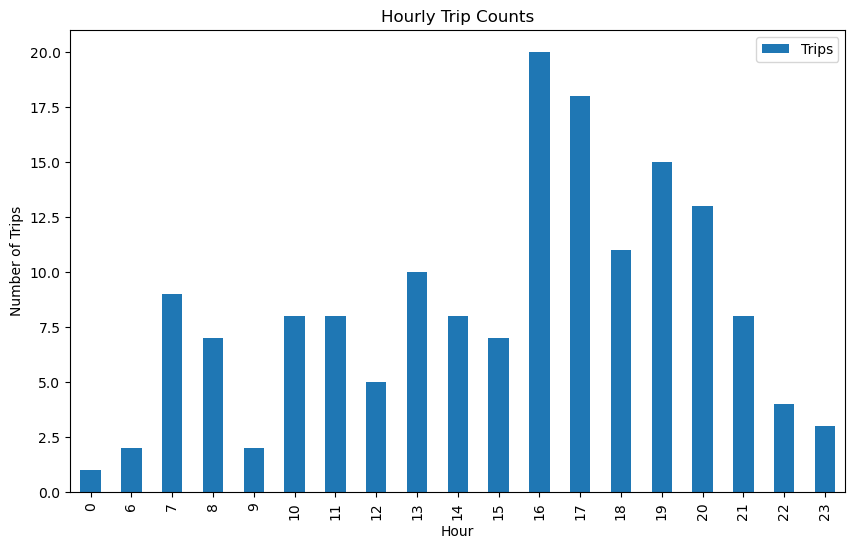

In [111]:
from matplotlib import pyplot as plt
# no of trips that started at each hour
trip_counts = df['Trip Start Time'].dt.hour.value_counts().sort_index()
hourly_trips = pd.DataFrame({
    'Hour': trip_counts.index,
    'Trips': trip_counts.values
})

hourly_trips.set_index('Hour', inplace=True)
hourly_trips.plot(kind='bar', figsize=(10, 6))

plt.title('Hourly Trip Counts')
plt.xlabel('Hour')
plt.ylabel('Number of Trips')
plt.show()

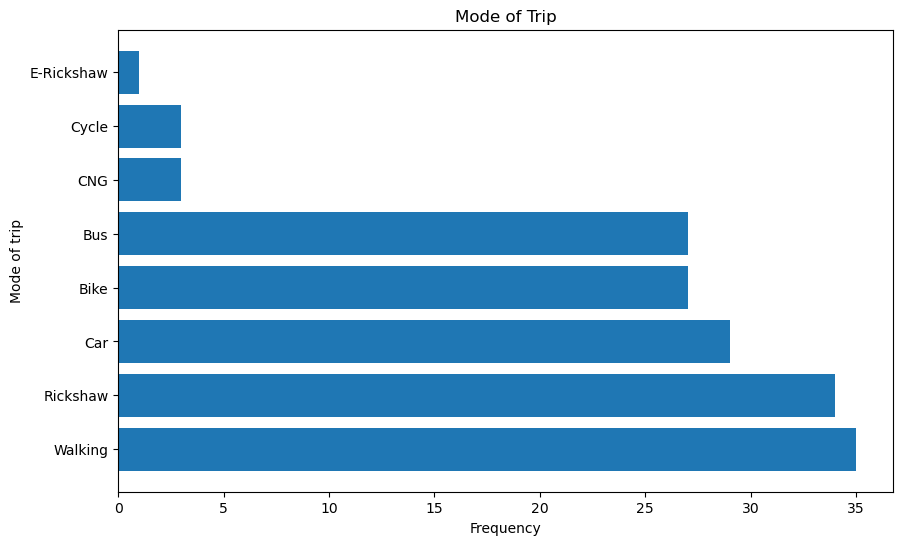

In [112]:
mode_freq = df['Trip Mode'].value_counts()


plt.figure(figsize=(10, 6))
plt.barh(mode_freq.index, mode_freq.values)


plt.xlabel('Frequency')
plt.ylabel('Mode of trip')
plt.title('Mode of Trip')


plt.show()